# Advanced Lane Detection

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Camera Calibration and Image Undistortion

In [2]:
# Create lists to store object points and image points from all images
objpoints = []
imgpoints = []

# Prepare object points
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Loop through calibration checkboard images and search for corners
for fname in glob('./camera_cal/calibration*.jpg'):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add to imgpoints, objpoints 
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [3]:
# Read an example calibration image
cal_img = mpimg.imread('./camera_cal/calibration2.jpg')

# Undistort image using camera calibration parameters
cal_undist = cv2.undistort(cal_img, mtx, dist, None, mtx)

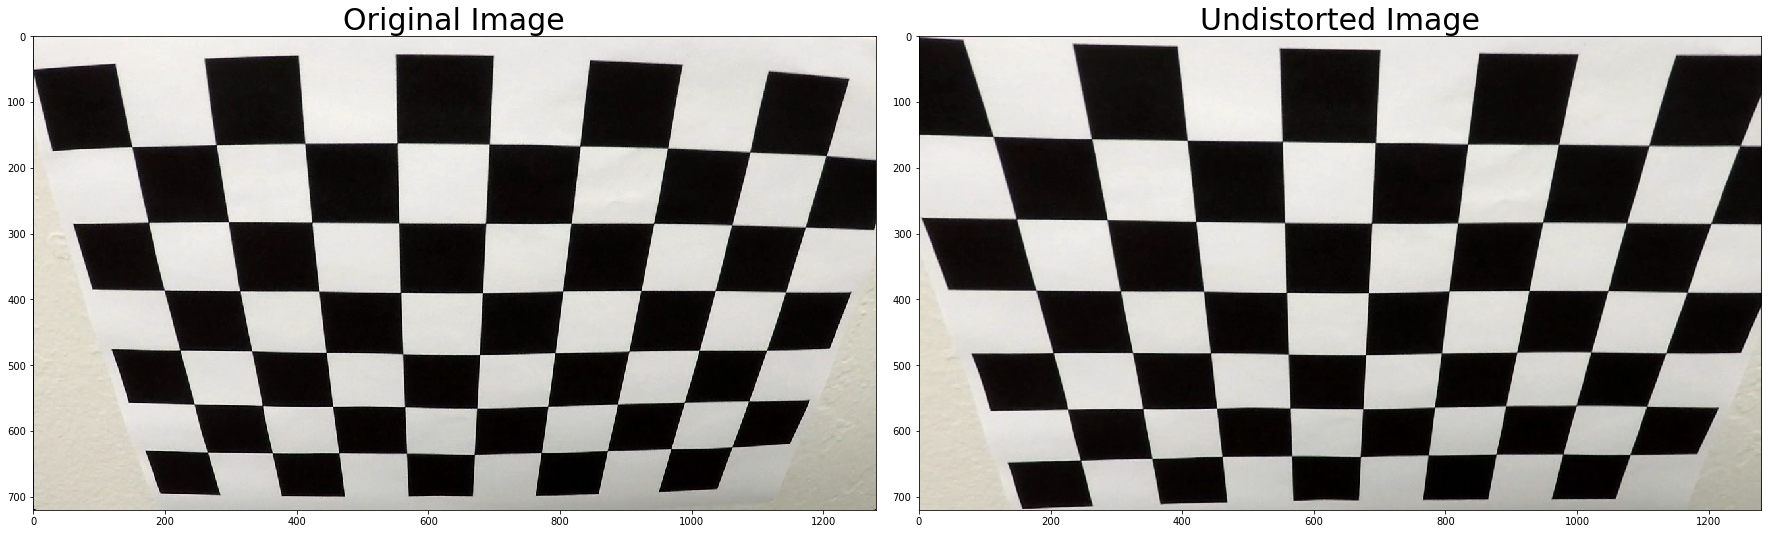

In [4]:
# Plot original and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cal_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Lane detection on Test images

In [5]:
# Read an example test image
test_img = mpimg.imread('./test_images/test5.jpg')

# Undistort image using camera calibration parameters
test_undist = cv2.undistort(test_img, mtx, dist, None, mtx)

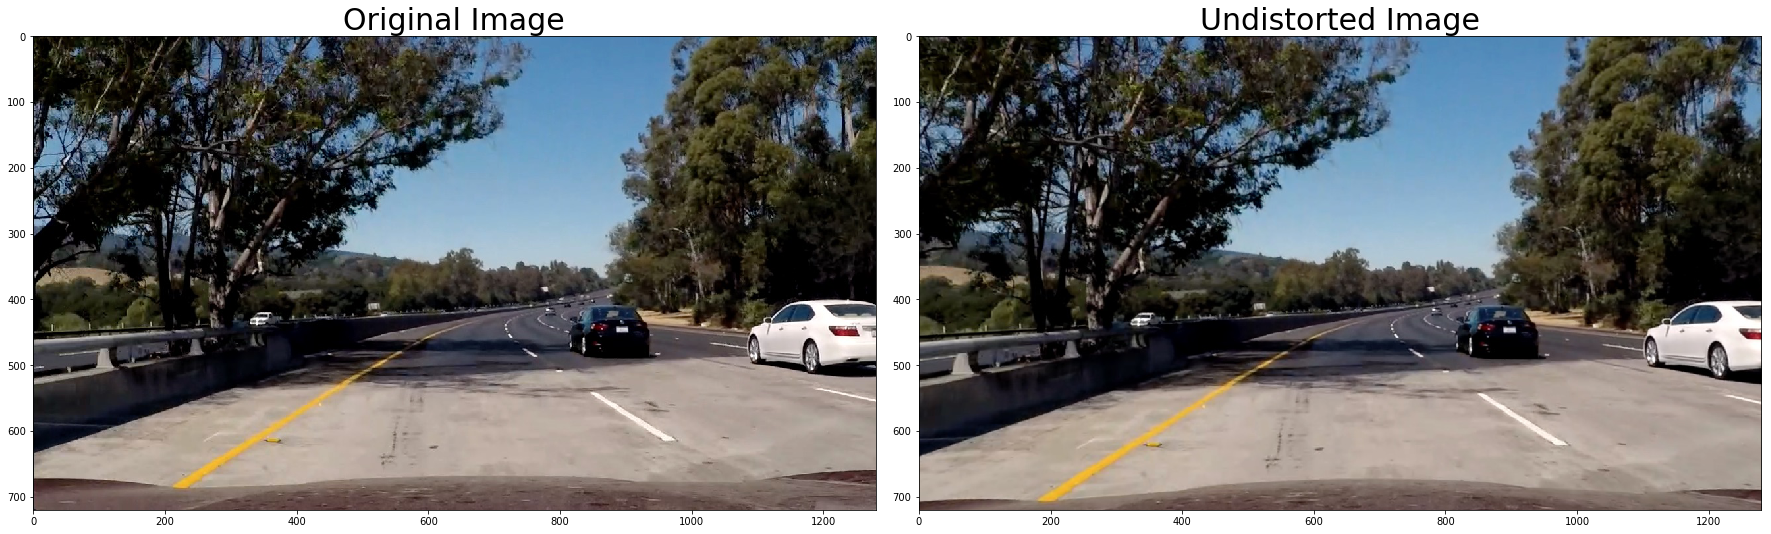

In [6]:
# Plot original and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Preprocessing image using HLS and Color thresholds

In [7]:
# Mask and threshold parameters

mask_vertices = np.array([[[182, 720], [500, 466], [782, 464], [1234, 720]]]) # mask

s_thresh = (90,255) # threshold in S channel
h_thresh = (15,105) # threshold in H channel
r_thresh = (200,255) #threshold in R channel

In [8]:
def preprocess(image,mask_vertices = mask_vertices, s_thresh = s_thresh, r_thresh = r_thresh, h_thresh = h_thresh):
    
    # mask image
    mask = np.uint8(np.zeros_like(image[:,:,0]))
    vertices = mask_vertices
    cv2.fillPoly(mask, vertices, (1))
    
    # threshold in H and S channels
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    H = hls[:,:,0]
    hs_binary = np.zeros_like(S)
    hs_binary[(S > s_thresh[0]) & (S <= s_thresh[1]) & (H > h_thresh[0]) & (H <= h_thresh[1])] = 1

    # threshold in R channel
    R = image[:,:,2]
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
    
    
    # combine the results
    combined_binary_masked = cv2.bitwise_and(cv2.bitwise_or(hs_binary,r_binary),mask)
    
    return combined_binary_masked

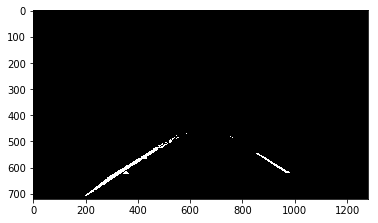

In [9]:
# Preprocessing the example test image
test_preproc = preprocess(test_undist)

# Plotting the resulting binary image
plt.imshow(test_preproc,cmap='gray')

### Perspective Transformation

In [10]:
# Parameters for perspective transformation

src = np.float32([[258, 679], [446, 549], [837, 549], [1045, 679]]) # perspective transform source
dst = np.float32([[258, 679], [258, 549], [837, 549], [837, 679]]) # perspective transform destionation

In [11]:
# Perspective tranformation to bird's eye view
M = cv2.getPerspectiveTransform(src, dst)

# Inverse transformation to original perspective
Minv = cv2.getPerspectiveTransform(dst, src)

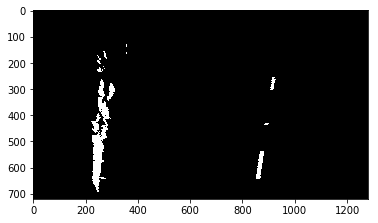

In [12]:
# Perspective transformation of the preprocessed example test image
test_warp = cv2.warpPerspective(test_preproc, M, test_preproc.shape[::-1], flags=cv2.INTER_LINEAR)

# Plotting the resulting warped image
plt.imshow(test_warp, cmap='gray')

### Finding lane lines using sliding window search

In [13]:
def find_lanes(binary_warped, nwindows = 6, margin = 100, minpix = 50):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right  halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
       
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return leftx, lefty, rightx, righty

def fit_polynomial(leftx, lefty, rightx, righty):
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def draw_curves(binary_warped, left_fit, right_fit):
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [14]:
# Detect lanes on the warped example test image
test_leftx, test_lefty, test_rightx, test_righty = find_lanes(test_warp)
test_left_fit, test_right_fit = fit_polynomial(test_leftx, test_lefty, test_rightx, test_righty)
test_left_fitx, test_right_fitx, test_ploty = draw_curves(test_warp, test_left_fit, test_right_fit)

(720, 0)

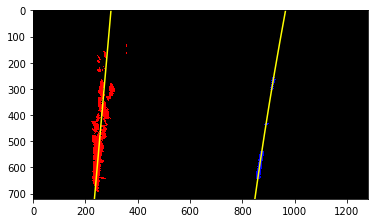

In [15]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((test_warp, test_warp, test_warp))*255

out_img[test_lefty, test_leftx] = [255, 0, 0]
out_img[test_righty, test_rightx] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(test_left_fitx, test_ploty, color='yellow')
plt.plot(test_right_fitx, test_ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Measuring curvature

In [16]:
def rad_curvature(binary_warped, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty):
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.int(np.max(ploty))
    #print(y_eval)
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters

    # Take the average of left and right radii
    radius = (left_curverad + right_curverad)/2.
    
    # left right lane positions in the pixels space
    left_lane_pos  = left_fitx[y_eval]
    right_lane_pos = right_fitx[y_eval]
    
    # deviation from center in meters
    deviation = ((right_lane_pos + left_lane_pos)/2. - 1280/2.)*xm_per_pix
    
    return [radius, deviation]

In [17]:
# Calculate radius of curvature and deviation from center in the example test image
test_radius, test_deviation = rad_curvature(test_warp, test_leftx, test_lefty, test_rightx, test_righty, test_left_fitx, test_right_fitx, test_ploty)
print(test_radius, test_deviation)

995.365023021 -0.520980439029


### Highlighting lane in the original image

In [18]:
def draw_lane(binary_warped, undistorted, left_fitx, right_fitx, ploty, Minv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0])) 
    
    # Combine the result with the original image
    image_highlighted = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    return image_highlighted

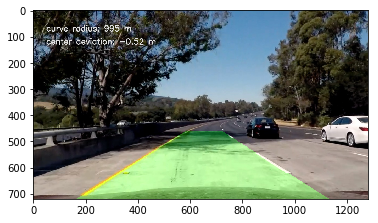

In [19]:
# Highlight lane in the example test image
test_image_highlighted = draw_lane(test_warp, test_undist, test_left_fitx, test_right_fitx, test_ploty, Minv)

# Print radius and deviation information on the image
cv2.putText(test_image_highlighted, "curve radius: {} m".format(int(test_radius)), (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,225,225), 2, cv2.LINE_AA)
cv2.putText(test_image_highlighted, "center deviation: {0:.2f} m".format(test_deviation), (50,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,225,225), 2, cv2.LINE_AA)

plt.imshow(test_image_highlighted)

## Building pipeline for lane detection given an image

In [20]:
def lane_detection(img, mtx, dist, src, dst, mask_vertices, s_thresh, r_thresh, h_thresh):
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_preproc = preprocess(img_undist, mask_vertices=mask_vertices,s_thresh=s_thresh,r_thresh=r_thresh, h_thresh=h_thresh)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_warp = cv2.warpPerspective(img_preproc, M, img_preproc.shape[::-1], flags=cv2.INTER_LINEAR)
    
    img_leftx, img_lefty, img_rightx, img_righty = find_lanes(img_warp)
    img_left_fit, img_right_fit = fit_polynomial(img_leftx, img_lefty, img_rightx, img_righty)
    img_left_fitx, img_right_fitx, img_ploty = draw_curves(img_warp, img_left_fit, img_right_fit)
    
    img_radius, img_deviation = rad_curvature(img_warp, img_leftx, img_lefty, img_rightx, img_righty, img_left_fitx, img_right_fitx, img_ploty)
    
    img_highlighted = draw_lane(img_warp, img_undist, img_left_fitx, img_right_fitx, img_ploty, Minv)
    
    cv2.putText(img_highlighted, "curve radius: {} m".format(int(img_radius)), (50,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,225,225), 2, cv2.LINE_AA)
    cv2.putText(img_highlighted, "center deviation: {0:.2f} m".format(img_deviation), (50,130), cv2.FONT_HERSHEY_SIMPLEX, 1, (225,225,225), 2, cv2.LINE_AA)
    
    return img_highlighted


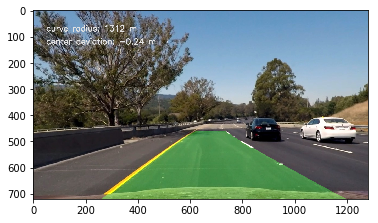

In [21]:
img = mpimg.imread('./test_images/test6.jpg')

mask_vertices = np.array([[[182, 720], [500, 466], [782, 464], [1234, 720]]])

img_highlighted = lane_detection(img, mtx, dist, src, dst, mask_vertices = mask_vertices, s_thresh = (90,255), r_thresh = (200,255), h_thresh = (15, 105))
plt.imshow(img_highlighted)

## Applying the pipeline to video

In [22]:
def process_frame(image):
    return lane_detection(image, mtx, dist, src, dst, mask_vertices, s_thresh, r_thresh, h_thresh)
    
project_video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:26<00:00,  8.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 7s, sys: 12.1 s, total: 3min 19s
Wall time: 2min 27s
